# MFCC from scratch

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

## Getting an audio file

In [25]:
audio_dir = '/home/joao/Desktop/datasets/data_speech_commands_v0.02/cat/' + 'ffd2ba2f_nohash_0.wav'
audio, sr = librosa.load(audio_dir, sr=None)
duration = librosa.get_duration(y=audio, sr=sr)
total_samples = sr*duration
print("Sample rate: {}".format(sr))
print("Audio duration: {}".format(duration))
print("Total number of samples: {}".format(total_samples))

Sample rate: 16000
Audio duration: 1.0
Total number of samples: 16000.0


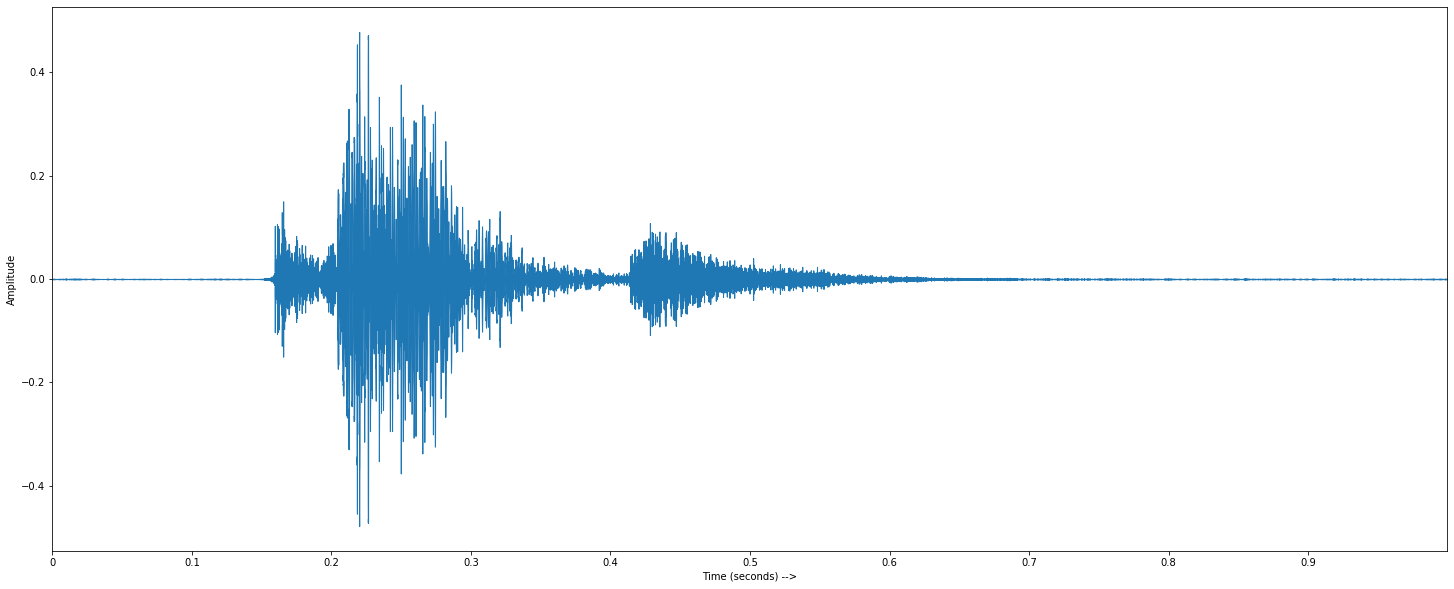

In [30]:
plt.figure(figsize=(25, 10))
librosa.display.waveplot(y=audio, sr=sr)
plt.xlabel("Time (seconds) -->")
plt.ylabel("Amplitude")
plt.show()

## Extracting Short-Time Fourier Transform

In [35]:
FRAME_SIZE
# HOP_SIZE

320.0

In [49]:
# FRAME_SIZE = 2048
# HOP_SIZE = 512
# S_scale = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
# FRAME_SIZE = 20 * 0.001 * sr # Frame size of all the samples that can fit 20ms of the audio sampled with 'sr'
# HOP_SIZE = FRAME_SIZE/4 # 25% of overlap
FRAME_SIZE = 320 # Frame size of all the samples that can fit 20ms of the audio sampled with 'sr'
HOP_SIZE = 320 # 25% of overlap
S_scale = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

In [50]:
S_scale.shape

(161, 51)

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.waveplot(y=S_scale, sr=sr)
plt.xlabel("Time (seconds) -->")
plt.ylabel("Amplitude")
plt.show()

## Calculating the spectrogram

In [51]:
Y_scale = np.abs(S_scale) ** 2

## Visualizing the spectrogram 

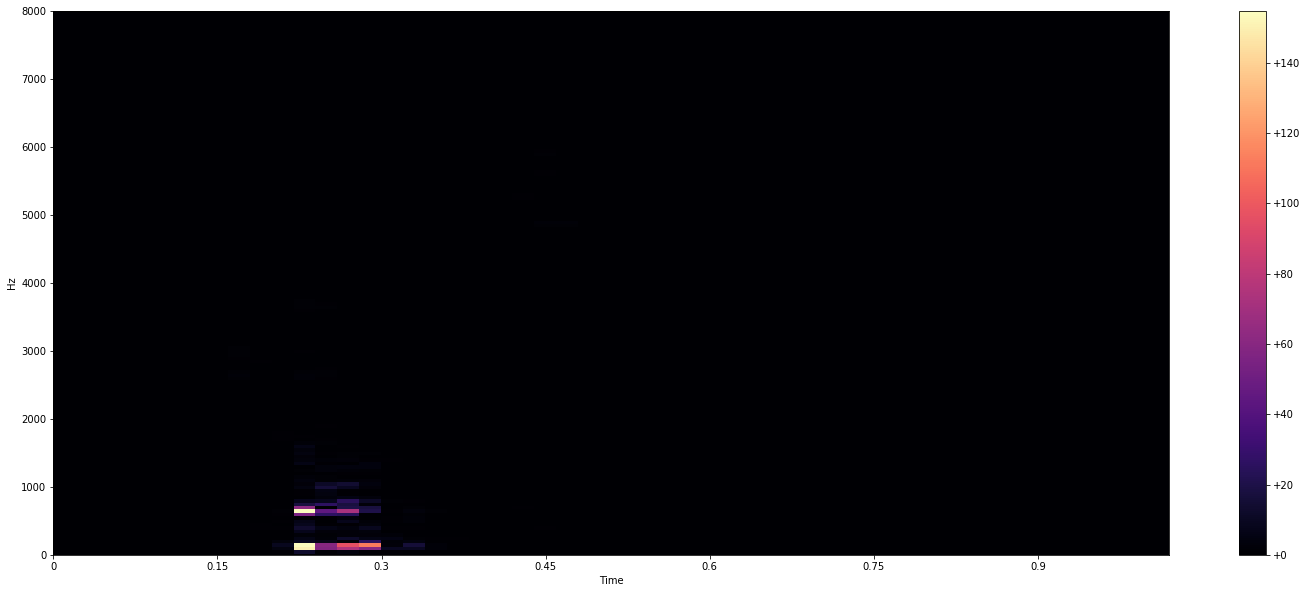

In [52]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

plot_spectrogram(Y_scale, sr, HOP_SIZE)

## Calculating the Mel filter banks

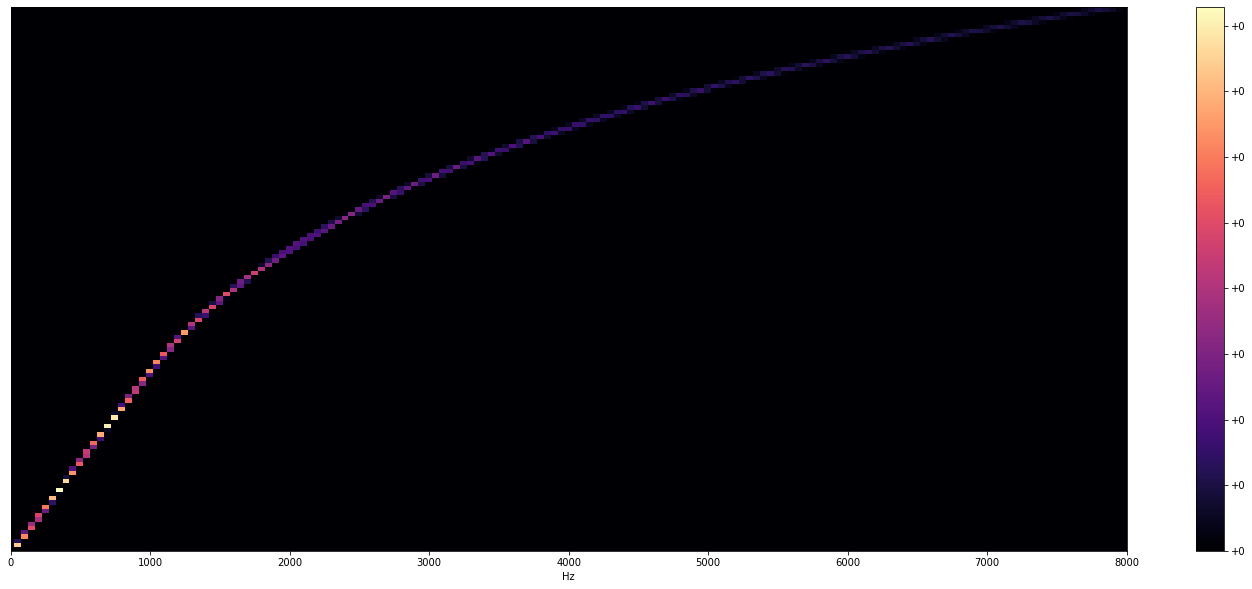

In [44]:
filter_banks = librosa.filters.mel(n_fft=FRAME_SIZE, sr=sr, n_mels=128)
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, 
                         sr=sr, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

## Computing log-power Mel spectrogram

In [54]:
n_mels = 128

S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=n_mels)

fft_windows = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
magnitude = np.abs(fft_windows)**2
mel = librosa.filters.mel(sr=sr, n_fft=FRAME_SIZE, n_mels=n_mels) # mel == filter_banks
melspectogram = mel.dot(magnitude)

assert (melspectogram == S).all()

In [55]:
melspectogram = librosa.feature.melspectrogram(audio, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=n_mels)
S = filter_banks.dot(Y_scale)
assert (melspectogram == S).all()

## Calculating MFCC

In [56]:
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))

## Visualizing MFCC

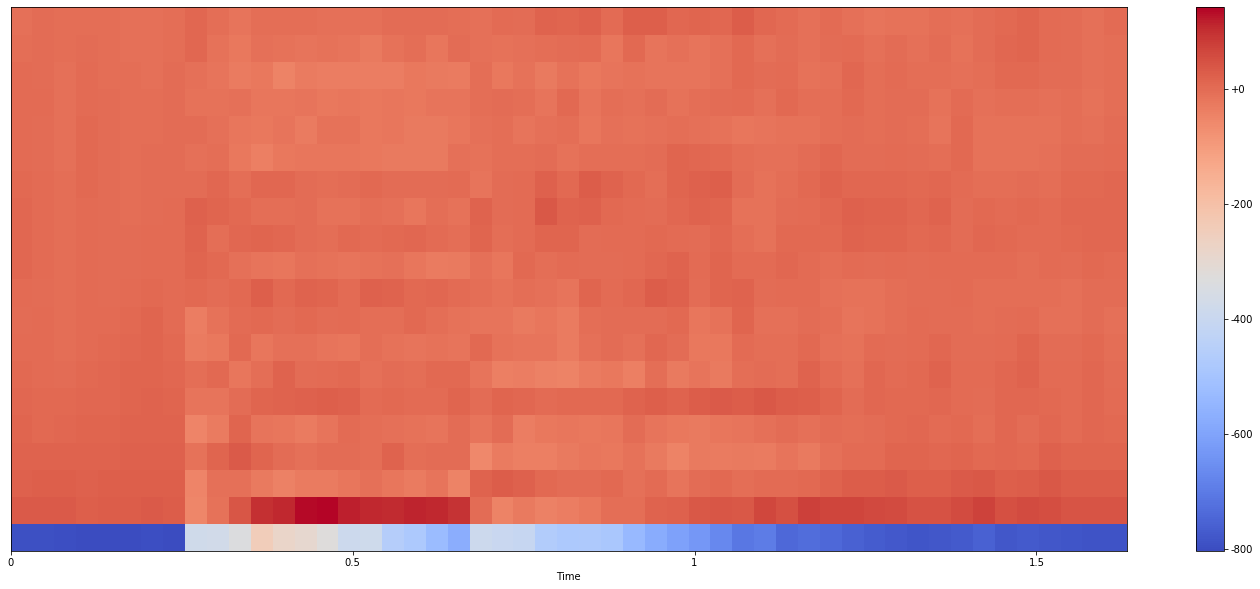

In [57]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [11]:
def alt_mfcc(audio, sr, n_fft=2048, hop_length=512, n_mels=128, num_ceps=13, cep_lifter=22):
    ##### Getting melspectrogram #####
    fft_windows = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(fft_windows)**2
    mel_filter_banks = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    melspectrogram = mel_filter_banks.dot(magnitude)
    ##### Getting the MFCC #####
    melspectrogram_db = librosa.power_to_db(melspectrogram)
    mfcc = dct(melspectrogram_db, type=2, axis=0, norm='ortho')[:num_ceps]
    if cep_lifter > 0:
        nframes,ncoeff = np.shape(mfcc)
        n = np.arange(ncoeff)
        cep_lifter = 1 + (cep_lifter/2.)*np.sin(np.pi*n/cep_lifter)
        mfcc = cep_lifter*mfcc 
        return mfcc
    elif cep_lifter == 0:
        return mfcc